# AVM CATASTRO

In [1]:
# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn import preprocessing
import json



#database
# import psycopg2
#import config_db

#plot
import seaborn as sns
import matplotlib.pyplot as plt

#models https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


#stats model 
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy
from scipy import stats
import math

#basic linear
from sklearn.linear_model import LinearRegression
#mush register
from sklearn.linear_model import SGDRegressor

#for important features
from sklearn.linear_model import Lasso # https://scikit-learn.org/stable/modules/linear_model.html#lasso
from sklearn.linear_model import ElasticNet # https://scikit-learn.org/stable/modules/linear_model.html#elastic-net
from sklearn.linear_model import LassoLars

#no important features
from sklearn.linear_model import Ridge #https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
from sklearn.svm import SVR #kernel linear https://scikit-learn.org/stable/modules/svm.html#regression
from sklearn.svm import LinearSVR

#Not working
#svr #kernel rbf https://scikit-learn.org/stable/modules/svm.html#regression
#ensemble https://scikit-learn.org/stable/modules/ensemble.html
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

#resampling
from sklearn.ensemble import BaggingRegressor
# scikit-learn bootstrap
from sklearn.utils import resample

#evaluation
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.tools.eval_measures as eval_measures

class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula,data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

def select_continuos_vars(df,min_cor = 0.3,response_var = 'log_vfventa2020'):
  cor_t = df.corr()
  cant_binm = ['vfventa2020','log_vfventa2020','avaluo_com','avaluo_cat']
  cont_cor = [v for v in cor_t[abs(cor_t[response_var]) > min_cor][response_var].index if (v not in cant_binm) and (not v.startswith("dm")) ]
  return cont_cor
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/DS4A 53/Project/Modeling/

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/DS4A 53/Project/Modeling


In [3]:
def fetch_data(skmodels = False,only_complete=False):
  ofertas = pd.read_csv('20201108 data.csv')
  ofertas.loc[ofertas['oft_tipo_inmueble'] == 'Depósito', 'oft_tipo_inmueble'] = 'Deposito'
  cat_data = ['preczhf','oft_tipo_inmueble','oft_tipo_norma_juridica','oia_tiene_ascensor','loccodigo',
            'suelo','actividad','tratamiento_urb','topografia','serpub','serpub_tipo','serpub_especif','via',
            'clase_via','estado_via','influencia_via','actividad_economica','actividad_economica_tipo','tipo_segun_actividad',
          'cp_terr_ar','estrato']
  for cd in cat_data:
      ofertas[cd] = ofertas[cd].astype('category')
      
  useless_cols = ['oft_codigo','lotcodigo','codigo_con','barmanpre','preczhf','codigo_res','manzana_id',
                  'nombre_barrio']

  ofertas.drop(columns=useless_cols,inplace=True)
  if only_complete:
    return ofertas.dropna()
  er_cols = ['oic_valor_adm','oic_valor_anexos','oia_tiene_ascensor','prevetustz']
  # ofertas_0 = ofertas.copy()
  ofertas.drop(columns=er_cols,inplace=True)
  ofertas.dropna(inplace=True)

  if skmodels:
    return ofertas
  Q1,Q3 = ofertas.vfventa2020.quantile(0.25),ofertas.vfventa2020.quantile(0.75)
  IQR = Q3-Q1
  ofertas_2 = ofertas.copy()
  
  # df = ofertas.copy()
  ofertas_2 = pd.get_dummies(ofertas_2)#for other models
  ofertas = ofertas[(ofertas.vfventa2020 > (Q1 - 1.5 * IQR)) & (ofertas.vfventa2020 < (Q3 + 1.5 * IQR))]
  return ofertas
ofertas = fetch_data(skmodels=True)
ofertas = ofertas[(ofertas.log_vfventa2020<22) & (ofertas.log_vfventa2020>16) & (np.sqrt(ofertas.oic_area_construccion) < 50)
                  & (np.sqrt(ofertas.oic_area_terreno) < 50)]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [21]:
def save_model_params(model_t,cv_data = ofertas,data=ofertas,resample =  False,tipo='General',estrato=False):
  pars = model_t.params
  pvals = model_t.pvalues
  list_vars =[]
  for i in range(len(pars.index)):
    list_vars.append({"Variable":pars.index[i],"Coefficient":pars[i],"p_value":pvals[i]})
  list_vars = [i for i in list_vars if not math.isnan(i['p_value'])]
  clf = statsmodel(smf.ols, model_t.model.formula)
  model_dict = {}
  model_dict['Type'] = tipo
  if estrato:
    model_dict['Estrato'] = estrato
  model_dict["Quantity of data"] = len(model_t.predict())
  if resample:
    cv = cross_val_score(clf, data, data.log_vfventa2020).mean()
    model_dict['R cuadrado'] = r2_score(cv_data.log_vfventa2020,model_t.predict(cv_data))
  else:
    model_dict['R-squared'] = model_t.rsquared
    model_dict['Adjusted R-squared'] = model_t.rsquared_adj
    cv = cross_val_score(clf, cv_data, cv_data.log_vfventa2020).mean()
  model_dict['Cross Validation score mean'] = cv
  model_dict['AIC'] = model_t.aic
  model_dict['BIC'] = model_t.bic
  model_dict['MSE'] = eval_measures.mse(cv_data.log_vfventa2020,model_t.predict(ofertas))
  model_dict['RMSE'] = eval_measures.rmse(cv_data.log_vfventa2020,model_t.predict(ofertas))
  # model_dict['RMSPE'] = eval_measures.rmspe(cv_data.log_vfventa2020,model_t.predict(ofertas))
  model_dict['variables'] = list_vars
  return model_dict

#data

In [ ]:
#database
#con = psycopg2.connect(database=config_db.database,user=config_db.user,password=config_db.password,host=config_db.host)
# con = psycopg2.connect(database='ofertas',user='team53',password='CatastroDS4A',host='ds4a53catastro.cd21iciz5zqe.us-east-2.rds.amazonaws.com')
# ofertas = pd.read_sql("select * from datos", con)
ofertas = pd.read_csv('20201108 data.csv')
ofertas.loc[ofertas['oft_tipo_inmueble'] == 'Depósito', 'oft_tipo_inmueble'] = 'Deposito'
total_registers = (len(ofertas.index))
total_columns = (len(ofertas.columns))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
ofertas.head()

,oft_codigo,lotcodigo,nombre_barrio,oft_tipo_inmueble,oft_tipo_norma_juridica,oic_area_terreno,oic_area_construccion,oic_valor_adm,oic_valor_anexos,oia_tiene_ascensor,oia_cant_garajes,vfventa2020,codigo_con,codigo_res,x,y,d_park,d_highway,d_bikeway,d_ssf,d_mus,d_lib,d_sitp,d_tm,d_p_tm,d_gy,d_ies,d_bom,d_col,d_ips,dm_bikeway,dm_bom,dm_col,dm_gy,dm_highway,dm_ies,dm_ips,dm_lib,dm_mus,dm_park,dm_p_tm,dm_sitp,dm_ssf,dm_tm,loccodigo,locnombre,z,barmanpre,preczhf,suelo,actividad,tratamiento_urb,topografia,serpub,serpub_tipo,serpub_especif,via,clase_via,estado_via,influencia_via,actividad_economica,actividad_economica_tipo,tipo_segun_actividad,manzana_id,cp_terr_ar,avaluo_com,avaluo_cat,log_vfventa2020,estrato,prevetustz
0,338319,9114036002,GILMAR,Apartamento,PH,1.0,154.30,400000.0,0.0,NO,2,8.385538e+08,1.0,9001.0,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,9114036002,6612125153114,6,61,21,2,51,5,1,531,5,3,1,14,1,4,9114036,P,2833333.0,2173704.0,20.547189,5.0,NaN
1,338320,9114036002,GILMAR,Apartamento,PH,1.0,154.30,400000.0,0.0,NO,2,8.980613e+08,1.0,9001.0,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,9114036002,6612125153114,6,61,21,2,51,5,1,531,5,3,1,14,1,4,9114036,P,2833333.0,2173704.0,20.615749,5.0,NaN
2,338321,8312005016,ESPARTILLAL,Oficina,PH,1.0,77.63,692000.0,0.0,SI,2,5.576739e+08,1.0,6002.0,1.002157e+06,1.007369e+06,176.040380,80.395866,262.720201,2535.917825,425.246626,2842.550861,58.876229,335.001609,7184.778515,1734.626853,105.485195,1691.440905,491.935033,6.279318,310.614444,2088.308464,675.004922,2297.591306,141.837730,184.288849,24.179026,3660.671996,622.041676,200.283583,8112.431909,129.976952,3208.664478,582.411375,2.0,CHAPINERO,2565.440497,8312005016,6452315152122,6,45,23,1,51,5,1,521,5,2,1,22,2,2,8312005,N,5800000.0,4930000.0,20.139285,5.0,NaN
3,338323,9124001039,PUENTE LARGO,Apartamento,PH,1.0,94.50,382000.0,0.0,NO,2,4.279725e+08,1.0,3002.0,1.001184e+06,1.011152e+06,39.862132,197.631985,217.813959,3511.786174,2548.295866,2879.444435,201.146286,449.852551,5006.047133,3663.701858,1150.395691,2954.407099,324.595001,155.957758,306.796430,3338.924183,441.317970,4764.539245,288.838433,1391.180606,269.738273,3263.703055,3048.418357,79.298390,6021.974309,422.752810,4345.943404,637.196995,11.0,SUBA,2558.471054,9124001039,6222115152115,6,22,21,1,51,5,1,521,5,2,1,15,1,5,9124001,P,3910586.0,2952398.0,19.874570,5.0,NaN
4,338324,8412054021,SANTA BIBIANA,Apartamento,PH,1.0,128.60,650000.0,0.0,NO,2,1.051021e+09,1.0,5003.0,1.002798e+06,1.010680e+06,109.315253,124.598558,4.642318,3678.832326,1879.858494,4211.971813,142.811580,413.261916,6693.263262,3967.405952,103.326581,4075.981245,279.132676,102.726665,38.278663,4742.141015,560.686525,4552.293612,140.984048,115.379418,163.595361,5387.519156,2594.299510,214.594010,8352.744279,260.115731,4587.553062,2118.277891,1.0,USAQUEN,2552.554726,8412054021,6222215153215,6,22,22,1,51,5,1,532,5,3,2,15,1,5,8412054,P,5457414.0,4287253.0,20.773028,6.0,NaN


In [ ]:
total_registers

86971

In [ ]:
#transform data
cat_data = ['preczhf',
            'oft_tipo_inmueble',
            'oft_tipo_norma_juridica',
            'oia_tiene_ascensor',
            'loccodigo',
            'suelo',
            'actividad',
            'tratamiento_urb',
            'topografia',
            'serpub',
            'serpub_tipo',
            'serpub_especif',
            'via',
            'clase_via',
            'estado_via',
            'influencia_via',
            'actividad_economica',
            'actividad_economica_tipo',
            'tipo_segun_actividad',
            'cp_terr_ar',
            'estrato']
for cd in cat_data:
    ofertas[cd] = ofertas[cd].astype('category')
    
useless_cols = ['oft_codigo',
                'lotcodigo',
                'codigo_con',
                'barmanpre',
                'preczhf',
                'codigo_res',
                'manzana_id',
                'nombre_barrio']

ofertas.drop(columns=useless_cols,inplace=True)
#drop manhatan
# for i in ofertas.columns:
#     if i.startswith("DM"):
#         ofertas.drop(columns=i,inplace=True)
#drop nas
# ofertas.dropna(inplace= True)
ofertas.head()

,oft_tipo_inmueble,oft_tipo_norma_juridica,oic_area_terreno,oic_area_construccion,oic_valor_adm,oic_valor_anexos,oia_tiene_ascensor,oia_cant_garajes,vfventa2020,x,y,d_park,d_highway,d_bikeway,d_ssf,d_mus,d_lib,d_sitp,d_tm,d_p_tm,d_gy,d_ies,d_bom,d_col,d_ips,dm_bikeway,dm_bom,dm_col,dm_gy,dm_highway,dm_ies,dm_ips,dm_lib,dm_mus,dm_park,dm_p_tm,dm_sitp,dm_ssf,dm_tm,loccodigo,locnombre,z,suelo,actividad,tratamiento_urb,topografia,serpub,serpub_tipo,serpub_especif,via,clase_via,estado_via,influencia_via,actividad_economica,actividad_economica_tipo,tipo_segun_actividad,cp_terr_ar,avaluo_com,avaluo_cat,log_vfventa2020,estrato,prevetustz
0,Apartamento,PH,1.0,154.30,400000.0,0.0,NO,2,8.385538e+08,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,6,61,21,2,51,5,1,531,5,3,1,14,1,4,P,2833333.0,2173704.0,20.547189,5.0,NaN
1,Apartamento,PH,1.0,154.30,400000.0,0.0,NO,2,8.980613e+08,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,6,61,21,2,51,5,1,531,5,3,1,14,1,4,P,2833333.0,2173704.0,20.615749,5.0,NaN
2,Oficina,PH,1.0,77.63,692000.0,0.0,SI,2,5.576739e+08,1.002157e+06,1.007369e+06,176.040380,80.395866,262.720201,2535.917825,425.246626,2842.550861,58.876229,335.001609,7184.778515,1734.626853,105.485195,1691.440905,491.935033,6.279318,310.614444,2088.308464,675.004922,2297.591306,141.837730,184.288849,24.179026,3660.671996,622.041676,200.283583,8112.431909,129.976952,3208.664478,582.411375,2.0,CHAPINERO,2565.440497,6,45,23,1,51,5,1,521,5,2,1,22,2,2,N,5800000.0,4930000.0,20.139285,5.0,NaN
3,Apartamento,PH,1.0,94.50,382000.0,0.0,NO,2,4.279725e+08,1.001184e+06,1.011152e+06,39.862132,197.631985,217.813959,3511.786174,2548.295866,2879.444435,201.146286,449.852551,5006.047133,3663.701858,1150.395691,2954.407099,324.595001,155.957758,306.796430,3338.924183,441.317970,4764.539245,288.838433,1391.180606,269.738273,3263.703055,3048.418357,79.298390,6021.974309,422.752810,4345.943404,637.196995,11.0,SUBA,2558.471054,6,22,21,1,51,5,1,521,5,2,1,15,1,5,P,3910586.0,2952398.0,19.874570,5.0,NaN
4,Apartamento,PH,1.0,128.60,650000.0,0.0,NO,2,1.051021e+09,1.002798e+06,1.010680e+06,109.315253,124.598558,4.642318,3678.832326,1879.858494,4211.971813,142.811580,413.261916,6693.263262,3967.405952,103.326581,4075.981245,279.132676,102.726665,38.278663,4742.141015,560.686525,4552.293612,140.984048,115.379418,163.595361,5387.519156,2594.299510,214.594010,8352.744279,260.115731,4587.553062,2118.277891,1.0,USAQUEN,2552.554726,6,22,22,1,51,5,1,532,5,3,2,15,1,5,P,5457414.0,4287253.0,20.773028,6.0,NaN


## Drop variables with much nans

In [ ]:
ofertas.isna().sum()

oft_tipo_inmueble               0
oft_tipo_norma_juridica         0
oic_area_terreno             3256
oic_area_construccion         664
oic_valor_adm               50537
oic_valor_anexos            50537
oia_tiene_ascensor          64632
oia_cant_garajes                0
vfventa2020                     0
x                               0
y                               0
d_park                          0
d_highway                       0
d_bikeway                       0
d_ssf                           0
d_mus                           0
d_lib                           0
d_sitp                          0
d_tm                            0
d_p_tm                          0
d_gy                            0
d_ies                           0
d_bom                           0
d_col                           0
d_ips                           0
dm_bikeway                      0
dm_bom                          0
dm_col                          0
dm_gy                           0
dm_highway    

In [ ]:
#drop for a lot of na values
er_cols = ['oic_valor_adm','oic_valor_anexos','oia_tiene_ascensor','prevetustz']
# ofertas_0 = ofertas.copy()
ofertas.drop(columns=er_cols,inplace=True)
ofertas.head()

,oft_tipo_inmueble,oft_tipo_norma_juridica,oic_area_terreno,oic_area_construccion,oia_cant_garajes,vfventa2020,x,y,d_park,d_highway,d_bikeway,d_ssf,d_mus,d_lib,d_sitp,d_tm,d_p_tm,d_gy,d_ies,d_bom,d_col,d_ips,dm_bikeway,dm_bom,dm_col,dm_gy,dm_highway,dm_ies,dm_ips,dm_lib,dm_mus,dm_park,dm_p_tm,dm_sitp,dm_ssf,dm_tm,loccodigo,locnombre,z,suelo,actividad,tratamiento_urb,topografia,serpub,serpub_tipo,serpub_especif,via,clase_via,estado_via,influencia_via,actividad_economica,actividad_economica_tipo,tipo_segun_actividad,cp_terr_ar,avaluo_com,avaluo_cat,log_vfventa2020,estrato
0,Apartamento,PH,1.0,154.30,2,8.385538e+08,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,6,61,21,2,51,5,1,531,5,3,1,14,1,4,P,2833333.0,2173704.0,20.547189,5.0
1,Apartamento,PH,1.0,154.30,2,8.980613e+08,1.001029e+06,1.016411e+06,0.000000,31.022020,132.624586,102.587985,2797.923570,1356.907787,251.030171,1631.847033,2591.530972,8781.765578,1878.591434,1306.720762,267.330342,632.441985,589.145548,1856.402509,545.193319,10944.909890,111.565198,2492.107311,733.827241,1558.177475,4239.753003,0.000000,4185.200310,432.420139,192.138505,2866.639842,11.0,SUBA,2564.825714,6,61,21,2,51,5,1,531,5,3,1,14,1,4,P,2833333.0,2173704.0,20.615749,5.0
2,Oficina,PH,1.0,77.63,2,5.576739e+08,1.002157e+06,1.007369e+06,176.040380,80.395866,262.720201,2535.917825,425.246626,2842.550861,58.876229,335.001609,7184.778515,1734.626853,105.485195,1691.440905,491.935033,6.279318,310.614444,2088.308464,675.004922,2297.591306,141.837730,184.288849,24.179026,3660.671996,622.041676,200.283583,8112.431909,129.976952,3208.664478,582.411375,2.0,CHAPINERO,2565.440497,6,45,23,1,51,5,1,521,5,2,1,22,2,2,N,5800000.0,4930000.0,20.139285,5.0
3,Apartamento,PH,1.0,94.50,2,4.279725e+08,1.001184e+06,1.011152e+06,39.862132,197.631985,217.813959,3511.786174,2548.295866,2879.444435,201.146286,449.852551,5006.047133,3663.701858,1150.395691,2954.407099,324.595001,155.957758,306.796430,3338.924183,441.317970,4764.539245,288.838433,1391.180606,269.738273,3263.703055,3048.418357,79.298390,6021.974309,422.752810,4345.943404,637.196995,11.0,SUBA,2558.471054,6,22,21,1,51,5,1,521,5,2,1,15,1,5,P,3910586.0,2952398.0,19.874570,5.0
4,Apartamento,PH,1.0,128.60,2,1.051021e+09,1.002798e+06,1.010680e+06,109.315253,124.598558,4.642318,3678.832326,1879.858494,4211.971813,142.811580,413.261916,6693.263262,3967.405952,103.326581,4075.981245,279.132676,102.726665,38.278663,4742.141015,560.686525,4552.293612,140.984048,115.379418,163.595361,5387.519156,2594.299510,214.594010,8352.744279,260.115731,4587.553062,2118.277891,1.0,USAQUEN,2552.554726,6,22,22,1,51,5,1,532,5,3,2,15,1,5,P,5457414.0,4287253.0,20.773028,6.0


## drop na value

In [ ]:
#drop the other na values and get the dummies
ofertas_1 = ofertas.copy()
ofertas.dropna(inplace=True)
# ofertas = pd.get_dummies(ofertas)

In [ ]:
registers_0 = len(ofertas.index)
print(f"Perdida total de {total_registers-registers_0} valores")

Perdida total de 7982 valores


## drop outliers

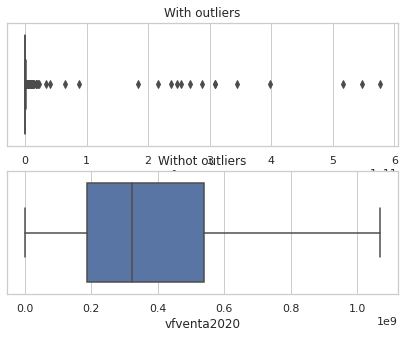

In [ ]:
sns.set_theme(style="whitegrid")
f, axes = plt.subplots(2,figsize=(7,5));
sns.boxplot(x=ofertas.vfventa2020,ax=axes[0])
axes[0].set_title('With outliers')
sns.boxplot(x=ofertas.vfventa2020,showfliers = False,ax=axes[1])
axes[1].set_title('Withot outliers');

In [ ]:
Q1,Q3 = ofertas.vfventa2020.quantile(0.25),ofertas.vfventa2020.quantile(0.75)
IQR = Q3-Q1
ofertas_2 = ofertas.copy()
df = ofertas.copy()
ofertas_2 = pd.get_dummies(ofertas_2)#for other models
ofertas = ofertas[(ofertas.vfventa2020 > (Q1 - 1.5 * IQR)) & (ofertas.vfventa2020 < (Q3 + 1.5 * IQR))]

In [ ]:
registers_1 = len(ofertas.index)
print(f"Se eliminan {registers_0-registers_1} outliers, perdida total de {total_registers-registers_1} valores")

Se eliminan 4832 outliers, perdida total de 12814 valores


## review normal distribution

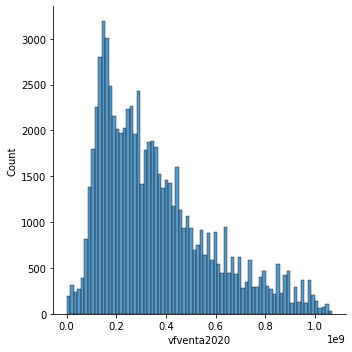

In [ ]:
sns.displot(ofertas.vfventa2020);

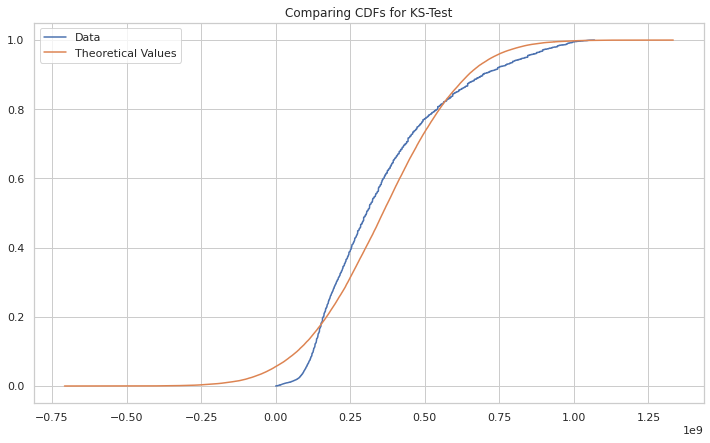

In [ ]:
def ks_plot_norm(data):
    length = len(data)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False))
    plt.plot(np.sort(stats.norm.rvs(loc=data.mean(), scale=data.std(), size=length)), np.linspace(0, 1, len(data), endpoint=False))
    plt.legend('top right')
    plt.legend(['Data', 'Theoretical Values'])
    plt.title('Comparing CDFs for KS-Test')
    
ks_plot_norm(ofertas.vfventa2020)

In [ ]:
# Kolmogorov Smirnov test
ks = stats.kstest(ofertas.vfventa2020,'norm')
ks.statistic,ks.pvalue

(1.0, 0.0)

reject hypotesis of normal distribution

In [ ]:
preprocessing.normalize(np.array(ofertas.log_vfventa2020).reshape(-1,1)).min()

1.0

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


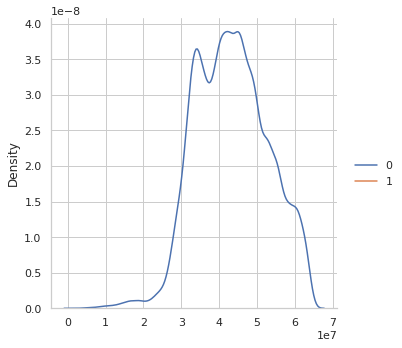

In [ ]:
sns.displot(stats.boxcox(ofertas.log_vfventa2020), kind="kde");

In [ ]:
stats.kstest(stats.boxcox(ofertas.vfventa2020)[0],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [ ]:
ofertas.estrato.value_counts()

3.0    24844
4.0    17826
2.0    14099
5.0     8527
6.0     6612
1.0     2249
Name: estrato, dtype: int64

''

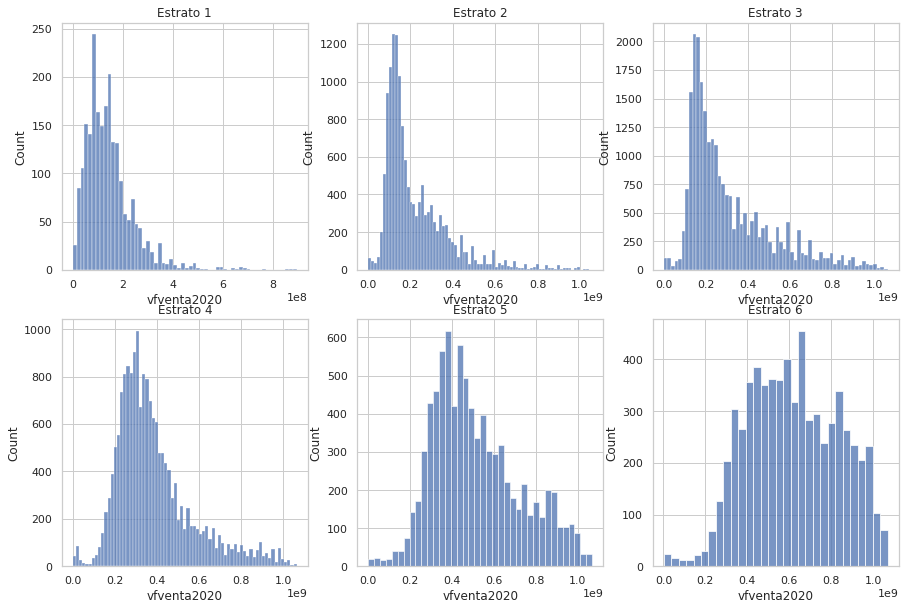

In [ ]:
f, axes = plt.subplots(2,3,figsize=(15,10));
sns.histplot(data=ofertas[ofertas.estrato == 1], x="vfventa2020",ax=axes[0,0]);
axes[0,0].set_title('Estrato 1')
sns.histplot(data=ofertas[ofertas.estrato == 2], x="vfventa2020",ax=axes[0,1]);
axes[0,1].set_title('Estrato 2')
sns.histplot(data=ofertas[ofertas.estrato == 3], x="vfventa2020",ax=axes[0,2]);
axes[0,2].set_title('Estrato 3')
sns.histplot(data=ofertas[ofertas.estrato == 4], x="vfventa2020",ax=axes[1,0]);
axes[1,0].set_title('Estrato 4')
sns.histplot(data=ofertas[ofertas.estrato == 5], x="vfventa2020",ax=axes[1,1]);
axes[1,1].set_title('Estrato 5')
sns.histplot(data=ofertas[ofertas.estrato == 6], x="vfventa2020",ax=axes[1,2]);
axes[1,2].set_title('Estrato 6')
;

variables que consideraria utiles y faciles de encontrar

In [ ]:
ofertas['act'] = ofertas['actividad'].apply(lambda x: str(x)[0])
ofertas['act'] = ofertas['act'].astype('category')

In [ ]:
ofertas.dtypes

In [ ]:
train, test = train_test_split(ofertas, test_size=0.3, random_state=123)

In [ ]:
test.shape,train.shape

((22248, 58), (51909, 58))

In [ ]:
ofertas.columns = [i.replace(' ','_') for i in ofertas.columns]
ofertas.columns = [i.replace('.0','') for i in ofertas.columns]
ofertas.columns = [i.replace('-','') for i in ofertas.columns]

# Models in all the data


## OLS

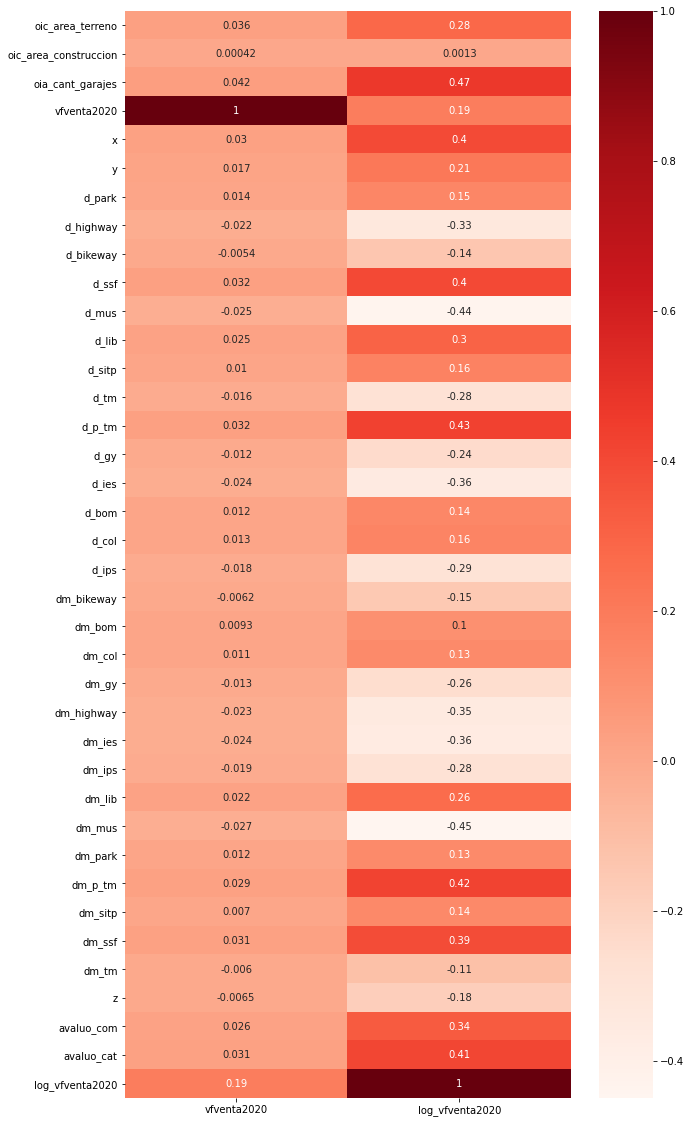

In [ ]:
plt.figure(figsize=(10,20))
cor = ofertas.corr()
sns.heatmap(cor[['vfventa2020','log_vfventa2020']], annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
cant_binm = ['vfventa2020','log_vfventa2020','avaluo_com','avaluo_cat']
cont_cor = [v for v in cor[abs(cor.log_vfventa2020) > 0.3]['log_vfventa2020'].index if (v not in cant_binm) and (not v.startswith("dm")) ]
cont_cor

['oia_cant_garajes',
 'x',
 'd_highway',
 'd_ssf',
 'd_mus',
 'd_lib',
 'd_p_tm',
 'd_ies']

In [ ]:
select_continuos_vars(ofertas)

['oia_cant_garajes',
 'x',
 'd_highway',
 'd_ssf',
 'd_mus',
 'd_tm',
 'd_p_tm',
 'd_ies',
 'd_ips']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(ofertas)),
                    data = ofertas).fit()
print(model_cont.summary())

                            OLS Regression Results                            
Dep. Variable:        log_vfventa2020   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     4778.
Date:                Tue, 10 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:06:16   Log-Likelihood:                -61329.
No. Observations:               74157   AIC:                         1.227e+05
Df Residuals:                   74147   BIC:                         1.228e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           19.9922      0.649  

In [ ]:
ofertas['oft_tipo_inmueble'].value_counts()

Apartamento                 48187
Casa                        22392
Casa uso mixto               3567
Oficina                      1159
Lote                          899
Local                         579
Bodega                        562
Edificio                      356
Apartaestudio                 327
Parqueadero                   289
Casa lote                     275
Deposito                      144
Inmueble comercial            106
Garaje                         79
Consultorio                    26
Dotacional                     23
Edificio comercial              8
Casa comercial                  3
Casa bodega                     3
Casa residencial                2
Parqueadero - lava autos        1
Casa campestre                  1
Bodega comercial                1
Industria                       0
Institucional                   0
Residencias-hotel               0
Name: oft_tipo_inmueble, dtype: int64

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=ofertas).fit()
print(model_cat.summary())

In [ ]:
model_cat.pvalues

Intercept                                 0.000000e+00
oft_tipo_inmueble[T.Apartamento]          4.519349e-50
oft_tipo_inmueble[T.Bodega]              8.542819e-304
oft_tipo_inmueble[T.Bodega comercial]     2.778944e-02
oft_tipo_inmueble[T.Casa]                3.878256e-288
                                             ...      
estrato[T.2.0]                           5.384001e-130
estrato[T.3.0]                            0.000000e+00
estrato[T.4.0]                            0.000000e+00
estrato[T.5.0]                            0.000000e+00
estrato[T.6.0]                            0.000000e+00
Length: 156, dtype: float64

In [ ]:
cat_data_model_2 = ['oft_tipo_inmueble','loccodigo','topografia','actividad_economica_tipo','estrato']
model_cat_2 = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model_2),data=ofertas).fit()
print(model_cat_2.summary())

In [9]:
ofertas = ofertas[(ofertas.log_vfventa2020<22) & (ofertas.log_vfventa2020>16) & (np.sqrt(ofertas.oic_area_construccion) < 50)
                  & (np.sqrt(ofertas.oic_area_terreno) < 50)]

In [12]:
len(ofertas.index)

78607

In [4]:
formula = """np.log(vfventa2020) ~ estrato + x  + y + topografia + d_tm + d_col + oft_tipo_inmueble +
              d_highway + oft_tipo_norma_juridica + np.sqrt(oic_area_terreno) + oia_cant_garajes +
              cp_terr_ar + suelo + d_p_tm + d_bom + d_mus +
                + dm_sitp + np.sqrt(oic_area_construccion)"""

# vars_model_t = (['oft_tipo_inmueble','loccodigo','estrato','oft_tipo_norma_juridica'] 
#                 + select_continuos_vars(ofertas))
model_t = smf.ols(formula,data=ofertas).fit()
print(model_t.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(vfventa2020)   R-squared:                       0.784
Model:                             OLS   Adj. R-squared:                  0.784
Method:                  Least Squares   F-statistic:                     6488.
Date:                 Sun, 15 Nov 2020   Prob (F-statistic):               0.00
Time:                         17:23:10   Log-Likelihood:                -30052.
No. Observations:                78607   AIC:                         6.019e+04
Df Residuals:                    78562   BIC:                         6.061e+04
Df Model:                           44                                         
Covariance Type:             nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [14]:
eval_measures.mse(ofertas.log_vfventa2020,model_t.predict(ofertas))

0.12577467119403457

In [13]:
eval_measures.rmse(ofertas.log_vfventa2020,model_t.predict(ofertas))

0.3546472489587852

In [16]:
save_model_params(model_t,cv_data = ofertas)

{'AIC': 60193.99458393938,
 'BIC': 60611.24430542329,
 'Cantidad de datos': 78607,
 'Cross Validation score mean': 0.7520346422428037,
 'MSE': 0.12577467119403457,
 'R cuadrado': 0.7842013293742477,
 'R cuadrado Ajustado': 0.7840804676152862,
 'RMSE': 0.3546472489587852,
 'Tipo': 'General',
 'variables': [{'Coeficiente': 20.064367072636387,
   'Variable': 'Intercept',
   'p_value': 0.0},
  {'Coeficiente': 0.24610172663295427,
   'Variable': 'estrato[T.2.0]',
   'p_value': 4.0367146246264396e-153},
  {'Coeficiente': 0.44470440933275635,
   'Variable': 'estrato[T.3.0]',
   'p_value': 0.0},
  {'Coeficiente': 0.7447133776822671,
   'Variable': 'estrato[T.4.0]',
   'p_value': 0.0},
  {'Coeficiente': 0.9616689032486945,
   'Variable': 'estrato[T.5.0]',
   'p_value': 0.0},
  {'Coeficiente': 1.1982179850039354,
   'Variable': 'estrato[T.6.0]',
   'p_value': 0.0},
  {'Coeficiente': -0.050235856949724746,
   'Variable': 'topografia[T.2]',
   'p_value': 4.790443849205231e-19},
  {'Coeficiente': -

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(ofertas.log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 9892.709477520113,
 'f p-value': 0.0,
 'f-value': 211.24269900622485,
 'p-value': 0.0}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(1.0787926394401837, 1.482920142626684e-13, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.23843234020752319, 0.0)

In [ ]:
formula_model_all = 'log_vfventa2020 ~ ' +' + '.join([i for i in list(ofertas) if i not in ['log_vfventa2020','vfventa2020']])
model_all  = smf.ols(formula_model_all , data = ofertas).fit()
print(model_all.summary())

In [ ]:
# wls doesnt work like in R
wts_df = pd.DataFrame({"y":abs(model_t.resid),"x": model_t.predict(ofertas)})
wts_model = smf.ols("y~x",data=wts_df).fit()
wts_sd = wts_model.predict(wts_df)
wts = 1/(wts_sd**2)
WLS = LinearRegression()

WLS.fit(X_low, ymod, sample_weight=wts)
# wts  <- 1/fitted( lm(abs(residuals(m))~fitted(m)) )^2

0        14.790080
1        14.790080
2        15.014487
3        14.969231
4        15.490023
           ...    
86966    15.434038
86967    15.759899
86968    13.972491
86969    14.120824
86970    13.502079
Length: 74157, dtype: float64

In [ ]:
model_wls = smf.wls(formula,data=ofertas,weights = wts).fit()
print(model_wls.summary())

# Models SCIKIT

In [6]:
vars_model_t_0 = (['oft_tipo_inmueble','loccodigo','estrato','oft_tipo_norma_juridica'] 
                + select_continuos_vars(ofertas))
# df = ofertas_1.dropna()[vars_model_t_0 +['log_vfventa2020','vfventa2020']]
# X = df[vars_model_t_0]
# df = fetch_data(skmodels=True)
# X_ = df[[c for c in df.columns if c not in ['log_vfventa2020','vfventa2020','avaluo_cat','avaluo_com']]]
# X_ = pd.get_dummies(X_)
# y_ = df['vfventa2020']
# X_train_, X_test_, y_train_, y_test_ = train_test_split( X_, y_, test_size=0.3, random_state=123)
df = ofertas
# df = resample(df, replace=True, n_samples=10000, random_state=123)
X = df[[c for c in df.columns if c not in ['log_vfventa2020','vfventa2020','avaluo_cat','avaluo_com']]]
X = pd.get_dummies(X)
y = df['vfventa2020']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=123)

In [ ]:
reg = LinearRegression()

reg.fit(X, y)#, sample_weight=wts)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
 import sklearn.metrics.classification_report

In [ ]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##sgd

In [ ]:
model_SGD = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
model_SGD.fit(X_train, y_train)#

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=None, shuffle=True, tol=0.001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

In [ ]:
model_SGD.score(X_test, y_test)

-9.690472953575871e+22

## Lasso

In [22]:
model_Lasso = Lasso(alpha=0.1,max_iter=10000,random_state=123)
model_Lasso.fit(X_train, y_train)#

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.752889217081864e+20, tolerance: 7.906009184937567e+17
  positive)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=123,
      selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
model_Lasso.predict(X)

array([5.69976751e+08, 5.69976751e+08, 6.52232122e+08, ...,
       2.09709294e+08, 1.57806539e+08, 1.39500120e+08])

In [35]:
def save_model_sklearn(model_t,cv_data = ofertas,tipo='General'):
  model_dict = {}
  model_dict['Tipo'] = tipo
  model_dict['Cantidad de datos'] = len(model_t.predict(X))
  model_dict['Score Train data'] = model_t.score(X_train,y_train)
  model_dict['Score Test data'] = model_t.score(X_test, y_test)
  model_dict['Score All data'] = model_t.score(X,y)
  cv = cross_val_score(model_t, X, y).mean()
  model_dict['Cross Validation score mean'] = cv

  model_dict['MSE'] = eval_measures.mse(y,model_t.predict(X))
  model_dict['RMSE'] = eval_measures.rmse(y,model_t.predict(X))
  # model_dict['RMSPE'] = eval_measures.rmspe(cv_data.log_vfventa2020,model_t.predict(ofertas))
  return model_dict

In [36]:
save_model_sklearn(model_Lasso,cv_data = ofertas)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.029810441690876e+20, tolerance: 9.419817505278111e+17
  positive)


KeyboardInterrupt: ignored

In [30]:
eval_measures.mse(y,model_Lasso.predict(X))

4.579731745998507e+16

In [ ]:
summary_lineal= {"model_id": 1,
                 "name": "Lasso",
                 "descripción":"Lasso",
                 "data":[
                 save_model_params(model_t,cv_data=ofertas)
                  ]}
summary_lasso = {
    
}
with open('model_summary/models.json', 'w') as fout:
    json.dump([summary_lineal, esquema_base], fout)

## Elastic Net

In [ ]:
model_ElNe = ElasticNet(alpha=0.1,max_iter=10000,random_state=123)#
model_ElNe.fit(X_train, y_train)#

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=123, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
model_ElNe.score(X_test, y_test)

-0.0012721161581901175

## Lasso Lars

In [ ]:
model_LassoL=LassoLars(alpha=.1)
# model1 = Lasso(alpha=0.1)
model_LassoL.fit(X_train, y_train)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [ ]:
model_LassoL.score(X_test, y_test)

-3.390896451027636e-05

## Ridge

In [ ]:
model_Ridge = Ridge(alpha=0.5)
model_Ridge.fit(X_train, y_train)#

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
model_Ridge.score(X_test, y_test)

0.0038694765723101816

## SVR 

### kernel linear

In [ ]:
model_linSVR = make_pipeline(
                     LinearSVR(random_state=0, tol=1e-5))
model_linSVR.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('linearsvr',
                 LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
                           intercept_scaling=1.0, loss='epsilon_insensitive',
                           max_iter=1000, random_state=0, tol=1e-05,
                           verbose=0))],
         verbose=False)

In [ ]:
model_linSVR.score(X_test, y_test)

0.0014404636180614938

### kernel rbf

In [ ]:
# model_SVR = SVR()
# model_SVR.fit(X_train, y_train)#

In [ ]:
# model_SVR.score(X_test, y_test)

## Ensemble Random Forest

In [7]:
model_RFR = RandomForestRegressor(n_estimators = 10,
                                   random_state = 123,
                                  #  max_depth = 10,
                                  #  bootstrap=True,
                                   max_features=50)
model_RFR.fit(X_train, y_train)#

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=50, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [8]:
dict(zip(['Score in training','Score in test','Score in all the data'],
         [model_RFR.score(X_train, y_train),model_RFR.score(X_test, y_test),model_RFR.score(X, y)]))

{'Score in all the data': 0.9361370305607091,
 'Score in test': 0.8558488854531827,
 'Score in training': 0.9700471443749062}

In [ ]:
dict(zip(['Score in training','Score in test','Score in all the data'],
         [model_RFR.score(X_train, y_train),model_RFR.score(X_test, y_test),model_RFR.score(X, y)]))

{'Score in all the data': 0.4935505030688341,
 'Score in test': -0.18130908517482736,
 'Score in training': 0.6959520967800017}

In [26]:
feature_importances = pd.DataFrame(model_RFR.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.reset_index(inplace=True)
feature_importances.columns = ['V','i']
features_importances = feature_importances[feature_importances.i != 0]
list_vars = []
for i in range(len(features_importances.index)):
    list_vars.append({"Variable":features_importances.V[i],"Importance":features_importances.i[i]})
data_rf = {"Type":"General",
           'Quantity of train data':len(X_train),
 'Quantity of test data':len(X_test),
 'Score in training':model_RFR.score(X_train, y_train),
 'Score in test': model_RFR.score(X_test, y_test),
 'Score in all the data':model_RFR.score(X, y),
 'MSE' : eval_measures.mse(y,model_RFR.predict(X)),
 'RMSE' : eval_measures.rmse(y,model_RFR.predict(X)),
 'variables': list_vars}

In [ ]:
scores_R = cross_val_score(model_RFR, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_R.mean(), scores_R.std() * 2))

Accuracy: -1.80 (+/- 5.86)


In [ ]:
df_uncomplete = fetch_data(only_complete=True)
X_u = df_uncomplete[[c for c in df.columns if c not in ['log_vfventa2020','vfventa2020','avaluo_cat','avaluo_com']]]
X_u = pd.get_dummies(X_u)
y_u = df_uncomplete['vfventa2020']
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split( X_u, y_u, test_size=0.3, random_state=123)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
len(df_uncomplete.index)

6918

In [ ]:
model_RFR_u = RandomForestRegressor(n_estimators = 10,
                                   random_state = 123,
                                  #  max_depth = 10,
                                  #  bootstrap=True,
                                   max_features=50)
model_RFR_u.fit(X_train_u, y_train_u)#

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=50, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [ ]:
feature_importances_u = pd.DataFrame(model_RFR_u.feature_importances_,
                                   index = X_train_u.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances_u.reset_index(inplace=True)
feature_importances_u.columns = ['V','i']
features_importances_u = feature_importances_u[feature_importances_u.i != 0]
list_vars_u = []
for i in range(len(features_importances_u.index)):
    list_vars_u.append({"Variable":features_importances_u.V[i],"Importance":features_importances_u.i[i]})
{"Type":"General",
 'Score in training':model_RFR_u.score(X_train_u, y_train_u),
 'Score in test': model_RFR_u.score(X_test_u, y_test_u),
 'Score in all the data':model_RFR_u.score(X_u, y_u),
 'variables': list_vars_u}

In [ ]:
scores_R_u = cross_val_score(model_RFR_u, X_u, y_u, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_R_u.mean(), scores_R_u.std() * 2))

Accuracy: 0.69 (+/- 0.21)


## Ensemble Gradient boosting

In [15]:
model_GBR = GradientBoostingRegressor(random_state=1)
model_GBR.fit(X_train, y_train)#

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
dict(zip(['train_score','test_score','all_score'],
         [model_GBR.score(X_train, y_train),model_GBR.score(X_test, y_test),model_GBR.score(X, y)]))

{'all_score': 0.8196897739335025,
 'test_score': 0.8087177524949518,
 'train_score': 0.8243238356993572}

In [27]:
feature_importances = pd.DataFrame(model_GBR.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.reset_index(inplace=True)
feature_importances.columns = ['V','i']
features_importances = feature_importances[feature_importances.i != 0]
list_vars = []
for i in range(len(features_importances.index)):
    list_vars.append({"Variable":features_importances.V[i],"Importance":features_importances.i[i]})
data_gdr = {"Type":"General",
 'Quantity of train data':len(X_train),
 'Quantity of test data':len(X_test),
 'Score in training':model_GBR.score(X_train, y_train),
 'Score in test': model_GBR.score(X_test, y_test),
 'Score in all the data':model_GBR.score(X, y),
  'MSE' : eval_measures.mse(y,model_GBR.predict(X)),
 'RMSE' : eval_measures.rmse(y,model_GBR.predict(X)),
 'variables': list_vars}

In [32]:
scores = cross_val_score(model_GBR, X, y)
scores.mean()

0.7853377387808612

In [33]:
scores = cross_val_score(model_RFR, X, y)
scores.mean()

0.8184177972532943

In [ ]:
scores.mean()

In [29]:
 esquema_base = { "model_id": -1, 
        "name": "Base del esquema no borrar",
        "descripción":"Modelo regresion lineal simple logaritmo nivel",
        "data":[{
                    "Tipo": "General",
                    "R2_Adjust": "0.58",
                    "test_score":"0.8",
                    "cross_val":0.8
                }
        ] 
        }
summary_lineal_ols= {"model_id": 1,
                 "name": "Linear regression OLS",
                 "Description":"",
                 "data":[
                 save_model_params(model_t,cv_data = ofertas)
                  ]}
summary_lineal_wls= {"model_id": 2,
                 "name": "Linear regression WLS",
                 "Description":"",
                 "data":[
                 save_model_params(model_t,cv_data = ofertas)
                  ]}
summary_rf= {"model_id": 3,
                 "name": "Random forest",
                 "Description":"",
                 "data":[
                  data_rf
                  ]}
summary_gdr= {"model_id": 4,
                 "name": "Grading Boosting Regressor",
                 "Description":"",
                 "data":[
                  data_gdr
                  ]}
neural_network = {"model_id": 4, 
              "name": "Regression Neural Network", 
              "Description": "Neural Network implemented under Keras framework", 
              "data": [{"Type": "General", 
                  "Objective Function": "mean_squared_error", 
                  "optimizer": "Adam", 
                  "Architecture":"",
                  "Input Layer": "92 nodes", 
                  "First Hidden Layer": "4600 nodes", 
                  "Second Hidden Layer": "4600 nodes", 
                  "Third Hidden Layer": "4600 nodes", 
                  "Fourth Hidden Layer": "4600 nodes", 
                  "Output Layer": "1 nodes", 
                  "Final Objective Function Value (Loss)": "0.3553", 
                  "Final R Square Value (R2)": "0.5952", 
                  "Variables": ["x", 
                                  "y", 
                                  "d_park", 
                                  "d_highway", 
                                  "d_bikeway", 
                                  "d_ssf", 
                                  "d_mus", 
                                  "d_lib", 
                                  "d_sitp", 
                                  "d_tm", 
                                  "d_p_tm", 
                                  "d_gy", 
                                  "d_ies", 
                                  "d_bom", 
                                  "d_col", 
                                  "d_ips", 
                                  "oft_tipo_inmueble", 
                                  "oic_area_terreno", 
                                  "oia_cant_garajes", 
                                  "loccodigo", 
                                  "actividad_economica", 
                                  "estrato"]}]}
with open('model_summary/models_final.json', 'w') as fout:
    json.dump([summary_lineal_ols,summary_lineal_wls,summary_rf,summary_gdr, neural_network,esquema_base], fout)

In [ ]:
df['trans'] = np.exp(df.log_vfventa2020)

In [ ]:
df['pred'] = model_GBR.predict(X)

In [ ]:
df['trans_pred'] = np.exp(df.pred)

In [ ]:
df

,estrato,x,oic_area_construccion,oic_area_terreno,oia_cant_garajes,oft_tipo_norma_juridica,oft_tipo_inmueble,actividad_economica_tipo,serpub_tipo,loccodigo,d_highway,log_vfventa2020,vfventa2020,trans,pred,trans_pred
0,5.0,1.001029e+06,154.30,1.0,2,PH,Apartamento,1,5,11.0,31.022020,20.547189,8.385538e+08,8.385538e+08,20.498253,7.985060e+08
1,5.0,1.001029e+06,154.30,1.0,2,PH,Apartamento,1,5,11.0,31.022020,20.615749,8.980613e+08,8.980613e+08,20.498253,7.985060e+08
2,5.0,1.002157e+06,77.63,1.0,2,PH,Oficina,2,5,2.0,80.395866,20.139285,5.576739e+08,5.576739e+08,20.176196,5.786431e+08
3,5.0,1.001184e+06,94.50,1.0,2,PH,Apartamento,1,5,11.0,197.631985,19.874570,4.279725e+08,4.279725e+08,20.061542,5.159610e+08
4,6.0,1.002798e+06,128.60,1.0,2,PH,Apartamento,1,5,1.0,124.598558,20.773028,1.051021e+09,1.051021e+09,20.481596,7.853153e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86966,3.0,9.992487e+05,408.20,202.0,1,NPH,Casa,1,5,4.0,196.691247,20.543499,8.354650e+08,8.354650e+08,20.130742,5.529303e+08
86967,3.0,9.992839e+05,141.40,200.0,3,NPH,Casa,1,5,4.0,165.635066,19.853465,4.190350e+08,4.190350e+08,19.978240,4.747220e+08
86968,2.0,9.890125e+05,144.06,72.0,0,NPH,Casa,1,5,8.0,480.153439,19.266412,2.329680e+08,2.329680e+08,19.251274,2.294680e+08
86969,2.0,9.890178e+05,70.60,72.0,1,NPH,Casa,1,5,8.0,480.632058,19.178988,2.134660e+08,2.134660e+08,18.905151,1.623315e+08


In [ ]:
sel = SelectFromModel(RandomForestRegressor(random_state=123))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                                oob_score=False,
                                                random_state=123, verbose=0,
                                                warm

In [ ]:
len(pd.get_dummies(ofertas,drop_first=True).columns)

981

In [ ]:
selected_feat= X_train.columns[(sel.get_support())]
selected_feat

Index(['oic_area_terreno', 'oic_area_construccion', 'oia_cant_garajes', 'x',
       'd_park', 'd_highway', 'd_bikeway', 'd_ssf', 'd_mus', 'd_lib', 'd_sitp',
       'd_tm', 'd_p_tm', 'd_gy', 'd_ies', 'd_bom', 'd_col', 'd_ips',
       'dm_bikeway', 'dm_bom', 'dm_col', 'dm_gy', 'dm_highway', 'dm_ies',
       'dm_ips', 'dm_mus', 'dm_park', 'dm_p_tm', 'dm_sitp', 'dm_ssf', 'dm_tm',
       'z', 'avaluo_cat', 'actividad_46', 'actividad_economica_23'],
      dtype='object')

# Models by "estrato"

''

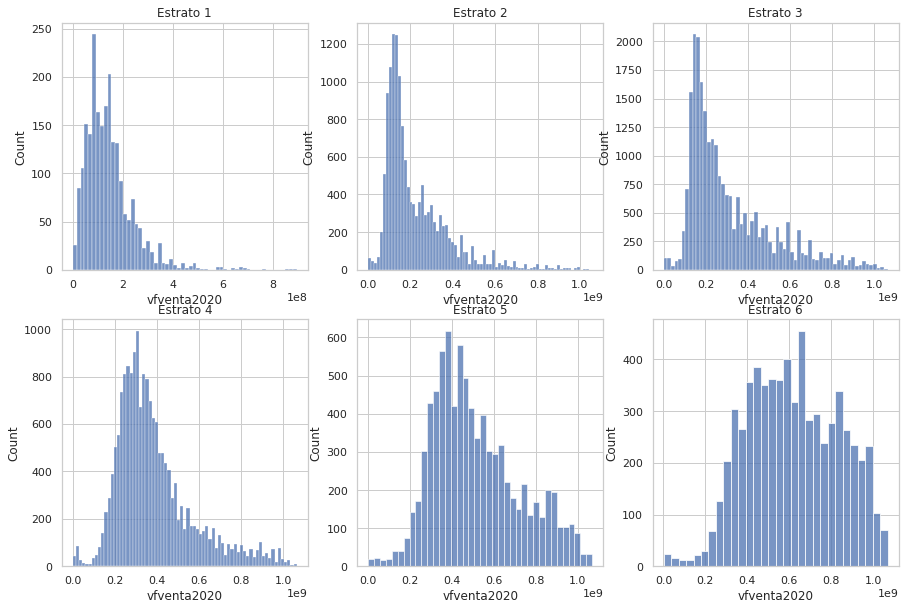

In [ ]:
f, axes = plt.subplots(2,3,figsize=(15,10));
sns.histplot(data=ofertas[ofertas.estrato == 1], x="vfventa2020",ax=axes[0,0]);
axes[0,0].set_title('Estrato 1')
sns.histplot(data=ofertas[ofertas.estrato == 2], x="vfventa2020",ax=axes[0,1]);
axes[0,1].set_title('Estrato 2')
sns.histplot(data=ofertas[ofertas.estrato == 3], x="vfventa2020",ax=axes[0,2]);
axes[0,2].set_title('Estrato 3')
sns.histplot(data=ofertas[ofertas.estrato == 4], x="vfventa2020",ax=axes[1,0]);
axes[1,0].set_title('Estrato 4')
sns.histplot(data=ofertas[ofertas.estrato == 5], x="vfventa2020",ax=axes[1,1]);
axes[1,1].set_title('Estrato 5')
sns.histplot(data=ofertas[ofertas.estrato == 6], x="vfventa2020",ax=axes[1,2]);
axes[1,2].set_title('Estrato 6')
;

In [ ]:
stats.pearsonr(ofertas.vfventa2020, ofertas.estrato.astype('int'))

(0.5323703844126016, 0.0)

In [ ]:
of_estratos= {n:ofertas[ofertas.estrato == n] for n in ofertas.estrato.unique()}

In [ ]:
{k:len(v.index) for k,v in of_estratos.items()}

{1.0: 2249, 2.0: 14099, 3.0: 24844, 4.0: 17826, 5.0: 8527, 6.0: 6612}

## ols

### Estrato 1

In [ ]:
select_continuos_vars(of_estratos[1])

['oic_area_construccion', 'd_bikeway', 'd_lib', 'z']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[1])),
                    data = of_estratos[1]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[1]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_1 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo'] 
                + select_continuos_vars(of_estratos[1]))
model_t_1 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_1),data=of_estratos[1]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_t_1,cv_data=of_estratos[1],tipo='Por estrato',estrato=1)

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[1].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 212.48913201318862,
 'f p-value': 5.564340000562853e-35,
 'f-value': 10.557290441678136,
 'p-value': 1.4311501588088038e-22}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(0.6793171337729894, 0.9999999999206174, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.22261929851773665, 2.1775338991709956e-98)

### Estrato 2

In [ ]:
select_continuos_vars(of_estratos[2])

['oic_area_terreno', 'd_park']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[2])),
                    data = of_estratos[2]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[2]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_2 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','topografia',
                 'serpub_tipo','actividad_economica_tipo','cp_terr_ar'] 
                + select_continuos_vars(of_estratos[2]))
model_t_2 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_2),data=res_estratos[2]).fit()

In [ ]:
model_t.model.formula

'log_vfventa2020 ~oft_tipo_inmueble + loccodigo + oft_tipo_norma_juridica + topografia + serpub_tipo + actividad_economica_tipo + cp_terr_ar + oic_area_terreno + d_park'

In [ ]:
clf = statsmodel(smf.ols, "log_vfventa2020 ~"+' + '.join(vars_model_t))

In [ ]:
save_model_params(model_t_2,cv_data=of_estratos[2],tipo='Por estrato',estrato=2)

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[2].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 3909.649443586821,
 'f p-value': 0.0,
 'f-value': 105.6828996579046,
 'p-value': 0.0}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(0.9049058265930973, 0.9999853871822412, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.2328501174880043, 0.0)

### Estrato 3

In [ ]:
select_continuos_vars(of_estratos[3])

['oic_area_terreno', 'oic_area_construccion', 'd_park', 'd_mus', 'd_gy']

In [ ]:
model_cont = smf.ols("vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[3])),
                    data = of_estratos[3]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[3]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_3 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo','topografia'] 
                + select_continuos_vars(of_estratos[3]))
model_t_3 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_3),data=of_estratos[3]).fit()

In [ ]:
save_model_params(model_t_3,cv_data=of_estratos[3],tipo='Por estrato',estrato=3)

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[3].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 4409.979493055417,
 'f p-value': 0.0,
 'f-value': 118.92875895277162,
 'p-value': 0.0}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(1.412412383403815, 3.908720244710902e-82, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.27097079791439665, 0.0)

### Estrato 4

In [ ]:
select_continuos_vars(of_estratos[4])

['oic_area_construccion', 'oia_cant_garajes']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[4])),
                    data = of_estratos[4]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[4]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_4 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo'] 
                + select_continuos_vars(of_estratos[4]))
model_t_4 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_4),data=of_estratos[4]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_t_4,cv_data=of_estratos[4],tipo='Por estrato',estrato=4)

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[4].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 5155.041600476712,
 'f p-value': 0.0,
 'f-value': 268.18232251282757,
 'p-value': 0.0}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(0.9147670218923277, 0.999986532261357, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.2790644925100419, 0.0)

### Estrato 5

In [ ]:
select_continuos_vars(of_estratos[5])

['oic_area_construccion', 'oia_cant_garajes']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[5])),
                    data = of_estratos[5]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[5]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_5 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','topografia'] 
                + select_continuos_vars(of_estratos[5]))
model_t_5 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_5),data=of_estratos[5]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_t_5,cv_data=of_estratos[5],tipo='Por estrato',estrato=5)

In [ ]:
ofertas[(ofertas.x == ofertas['x'].value_counts().index[0]) & (ofertas.y == ofertas['y'].value_counts().index[0])]

In [ ]:
ofertas['y'].value_counts().index[0]

998451.824913452

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[5].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 1750.9844891286589,
 'f p-value': 0.0,
 'f-value': 99.88688694209357,
 'p-value': 0.0}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(1.4566026460769779, 1.3596672092785158e-34, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.2896869981935412, 0.0)

### Estrato 6

In [ ]:
select_continuos_vars(of_estratos[6])

['oic_area_construccion', 'oia_cant_garajes']

In [ ]:
model_cont = smf.ols("log_vfventa2020 ~"+' + '.join(select_continuos_vars(of_estratos[6])),
                    data = of_estratos[6]).fit()
print(model_cont.summary())

In [ ]:
cat_data_model = [v for v in cat_data if v not in er_cols+useless_cols+['actividad','tratamiento_urb']]
model_cat = smf.ols("log_vfventa2020 ~"+' + '.join(cat_data_model),data=of_estratos[6]).fit()
print(model_cat.summary())

In [ ]:
vars_model_t_6 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica'] 
                + select_continuos_vars(of_estratos[6]))
model_t_6 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_t_6),data=of_estratos[6]).fit()


In [ ]:
save_model_params(model_t_6,cv_data=of_estratos[6],tipo='Por estrato',estrato=6)

In [ ]:
plt.figure(figsize=(20, 10))
sns.regplot(np.log(of_estratos[6].log_vfventa2020), model_t.resid,  color='coral')

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value',
'f-value', 'f p-value']
test = sms.het_breuschpagan(model_t.resid,model_t.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 126.24292082500172,
 'f p-value': 2.327219708988214e-20,
 'f-value': 9.172016009363876,
 'p-value': 2.0926147771346564e-09}

In [ ]:
sms.het_goldfeldquandt(model_t.resid,model_t.model.exog)

(1.4772557759899896, 3.278799369964264e-29, 'increasing')

In [ ]:
ks = stats.kstest(model_t.resid,'norm')
ks.statistic,ks.pvalue

(0.3097380617516727, 0.0)

# save linear_models to json

In [17]:
 esquema_base = { "model_id": -1, 
        "name": "Base del esquema no borrar",
        "descripción":"Modelo regresion lineal simple logaritmo nivel",
        "data":[{
                    "Tipo": "General",
                    "R2_Adjust": "0.58",
                    "test_score":"0.8",
                    "cross_val":0.8
                }
        ] 
        }

In [ ]:
summary_lineal= {"model_id": 1,
                 "name": "Regresión lineal simple log-lin",
                 "descripción":"Modelo regresion lineal simple estimado mediante minimos cuadrados ordinarios, donde se toma el logaritmo de la variable valor final de venta 2020 como variable respuesta",
                 "data":[
                 save_model_params(model_t),
                 { "Tipo":"Estrato",
                  "data":[
                 save_model_params(model_t_1,cv_data=of_estratos[1],tipo='Estrato',estrato=1),
                 save_model_params(model_t_2,cv_data=of_estratos[2],tipo='Estrato',estrato=2),
                 save_model_params(model_t_3,cv_data=of_estratos[3],tipo='Estrato',estrato=3),
                 save_model_params(model_t_4,cv_data=of_estratos[4],tipo='Estrato',estrato=4),
                 save_model_params(model_t_5,cv_data=of_estratos[5],tipo='Estrato',estrato=5),
                 save_model_params(model_t_6,cv_data=of_estratos[6],tipo='Estrato',estrato=6)
                 ]}
                  ]}
with open('model_summary/lineal_log_lin.json', 'w') as fout:
    json.dump([summary_lineal, esquema_base], fout)

In [20]:
summary_lineal= {"model_id": 1,
                 "name": "Regresión lineal simple log-lin",
                 "descripción":"Modelo regresion lineal simple estimado mediante minimos cuadrados ordinarios, donde se toma el logaritmo de la variable valor final de venta 2020 como variable respuesta",
                 "data":[
                 save_model_params(model_t,cv_data = ofertas)
                  ]}
with open('model_summary/lineal_log_lin.json', 'w') as fout:
    json.dump([summary_lineal, esquema_base], fout)


## RF

In [ ]:
models_Estrato_rf = {}
for e in df.estrato.unique():
  df_t = df[df.estrato == e]
  X_t = df_t[vars_model_t_0]
  X_t = pd.get_dummies(X_t)
  y_t = df_t['log_vfventa2020']
  X_train_t, X_test_t, y_train_t, y_test_t = train_test_split( X_t, y_t, test_size=0.3, random_state=123)
  model_GBR_t = RandomForestRegressor(random_state=123)
  model_GBR_t.fit(X_train_t, y_train_t)#
  scores_t = cross_val_score(model_GBR_t, X_t, y_t, cv=5)
  models_Estrato_rf[e] = {'model':model_GBR_t,
                       'score_test':model_GBR_t.score(X_test_t, y_test_t),
                       'score_train': model_GBR_t.score(X_train_t, y_train_t),
                       'score_all':model_GBR_t.score(X_t, y_t), 
                       'cv_score':scores_t.mean() }

In [ ]:
models_Estrato_rf

{1.0: {'cv_score': 0.24599974767638222,
  'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=123, verbose=0, warm_start=False),
  'score_all': 0.7925191099997876,
  'score_test': 0.520015468992558,
  'score_train': 0.9253288090794329},
 2.0: {'cv_score': 0.5357814443525767,
  'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_

## GBR

In [ ]:
models_Estrato = {}
for e in df.estrato.unique():
  df_t = df[df.estrato == e]
  X_t = df_t[vars_model_t_0]
  X_t = pd.get_dummies(X_t)
  y_t = df_t['log_vfventa2020']
  X_train_t, X_test_t, y_train_t, y_test_t = train_test_split( X_t, y_t, test_size=0.3, random_state=123)
  model_GBR_t = GradientBoostingRegressor(random_state=1)
  model_GBR_t.fit(X_train_t, y_train_t)#
  scores_t = cross_val_score(model_GBR_t, X_t, y_t, cv=5)
  models_Estrato[e] = {'model':model_GBR_t,
                       'score_test':model_GBR_t.score(X_test_t, y_test_t),
                       'score_train': model_GBR_t.score(X_train_t, y_train_t),
                       'score_all':model_GBR_t.score(X_t, y_t), 
                       'cv_score':scores_t.mean() }

In [ ]:
models_Estrato

{1.0: {'cv_score': 0.30203033489453857,
  'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                            init=None, learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=1, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0, warm_start=False),
  'score_all': 0.5996854732855559,
  'score_test': 0.4304837794182298,
  'score_train': 0.682032300853142},
 2.0: {'cv_score': 0.47447851363001103,
  'model': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                            init

# Resample

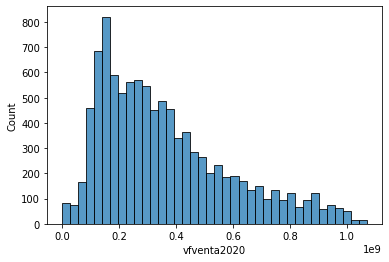

In [ ]:
boot = resample(ofertas, replace=True, n_samples=10000, random_state=123)
sns.histplot(boot.vfventa2020);

In [ ]:
ofertas_resample = resample(ofertas, replace=True, n_samples=round(len(ofertas.index)*.6), random_state=123)

In [ ]:
vars_model_r = (['oft_tipo_inmueble','loccodigo','estrato','oft_tipo_norma_juridica'] 
                + select_continuos_vars(ofertas_resample))
model_r = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r),data=ofertas_resample).fit()
print(model_r.summary())

                            OLS Regression Results                            
Dep. Variable:        log_vfventa2020   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     1858.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:28:26   Log-Likelihood:                -21085.
No. Observations:               44494   AIC:                         4.228e+04
Df Residuals:                   44440   BIC:                         4.275e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [ ]:
model_r.model.formula

'log_vfventa2020 ~oft_tipo_inmueble + loccodigo + estrato + oft_tipo_norma_juridica + oic_area_construccion + oia_cant_garajes + x + d_highway + d_ssf + d_mus + d_tm + d_p_tm + d_ies + d_ips'

In [ ]:
clf = statsmodel(smf.ols, model_r.model.formula)
cv = cross_val_score(clf, ofertas, ofertas.log_vfventa2020).mean()


In [ ]:
model_r.predict()

array([19.42948491, 19.32899246, 18.56113051, ..., 18.78861757,
       18.89305484, 19.98049736])

In [ ]:
ofertas.log_vfventa2020

0        20.547189
1        20.615749
2        20.139285
3        19.874570
4        20.773028
           ...    
86966    20.543499
86967    19.853465
86968    19.266412
86969    19.178988
86970    19.031766
Name: log_vfventa2020, Length: 74157, dtype: float64

In [ ]:
r2_score(ofertas_resample.log_vfventa2020,model_r.predict())

0.6892229951194766

In [ ]:
save_model_params(model_r,resample=True)

{'AIC': 42277.663201078496,
 'BIC': 42747.63112096906,
 'Cantidad de datos': 44494,
 'Cross Validation score mean': -468.35323762750147,
 'R cuadrado': -462.2553702691654,
 'Tipo': 'General',
 'variables': [{'Coeficiente': 24.369147612007094,
   'Variable': 'Intercept',
   'p_value': 3.2285137848550593e-37},
  {'Coeficiente': 0.28147945833401655,
   'Variable': 'oft_tipo_inmueble[T.Apartamento]',
   'p_value': 3.214160864459146e-22},
  {'Coeficiente': 0.9948951898819379,
   'Variable': 'oft_tipo_inmueble[T.Bodega]',
   'p_value': 4.084739769896687e-151},
  {'Coeficiente': 1.006890748578365,
   'Variable': 'oft_tipo_inmueble[T.Bodega comercial]',
   'p_value': 0.009877682658591125},
  {'Coeficiente': 0.6463978590439712,
   'Variable': 'oft_tipo_inmueble[T.Casa]',
   'p_value': 4.600605447468134e-105},
  {'Coeficiente': 1.4014448115817393,
   'Variable': 'oft_tipo_inmueble[T.Casa bodega]',
   'p_value': 6.362036003721474e-10},
  {'Coeficiente': -1.2740061927977194e-12,
   'Variable': 'of

In [ ]:
res_estratos = {k:resample(v, replace=True, n_samples=round(len(v.index)*.45), random_state=123) for k,v in of_estratos.items()}

In [ ]:
{k:len(v.index) for k,v in res_estratos.items()}

{1.0: 1012, 2.0: 6345, 3.0: 11180, 4.0: 8022, 5.0: 3837, 6.0: 2975}

### Estrato 1

In [ ]:
vars_model_r_1 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo'] 
                + select_continuos_vars(res_estratos[1]))
model_r_1 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_1),data=res_estratos[1]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_r_1,cv_data=of_estratos[1],tipo='Por estrato',estrato=1,resample=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


{'AIC': 1250.9615735463601,
 'BIC': 1369.033985942698,
 'Cantidad de datos': 1012,
 'Cross Validation score mean': 0.5039641960481442,
 'Estrato': 1,
 'R cuadrado': 0.6096948096957465,
 'Tipo': 'Por estrato',
 'variables': [{'Coeficiente': 17.5735098709603,
   'Variable': 'Intercept',
   'p_value': 1.1894221297484766e-163},
  {'Coeficiente': 2.0255391672770715,
   'Variable': 'oft_tipo_inmueble[T.Apartamento]',
   'p_value': 2.4788686075269284e-72},
  {'Coeficiente': 2.4561881354195076,
   'Variable': 'oft_tipo_inmueble[T.Bodega]',
   'p_value': 1.400695298106674e-66},
  {'Coeficiente': -7.263654029328256e-12,
   'Variable': 'oft_tipo_inmueble[T.Bodega comercial]',
   'p_value': 6.636725406862863e-157},
  {'Coeficiente': 2.097029706460886,
   'Variable': 'oft_tipo_inmueble[T.Casa]',
   'p_value': 3.9062327102838834e-96},
  {'Coeficiente': 4.329146897190639e-13,
   'Variable': 'oft_tipo_inmueble[T.Casa bodega]',
   'p_value': 1.616336887101652e-133},
  {'Coeficiente': 2.558962297611121e

### Estrato 2

In [ ]:
vars_model_r_2 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','topografia',
                 'serpub_tipo','actividad_economica_tipo','cp_terr_ar'] 
                + select_continuos_vars(of_estratos[2]))
model_r_2 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_2),data=res_estratos[2]).fit()

In [ ]:
save_model_params(model_r_2,cv_data=of_estratos[2],tipo='Por estrato',estrato=2,resample=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


{'AIC': 6479.872372393926,
 'BIC': 6777.110957120459,
 'Cantidad de datos': 6345,
 'Cross Validation score mean': 0.5319090236186004,
 'Estrato': 2,
 'R cuadrado': 0.5899144438363891,
 'Tipo': 'Por estrato',
 'variables': [{'Coeficiente': 17.111362324555916,
   'Variable': 'Intercept',
   'p_value': 0.0},
  {'Coeficiente': 1.3987795558207374,
   'Variable': 'oft_tipo_inmueble[T.Apartamento]',
   'p_value': 9.041656962739881e-211},
  {'Coeficiente': 1.9000757301869233,
   'Variable': 'oft_tipo_inmueble[T.Bodega]',
   'p_value': 2.124646450245365e-167},
  {'Coeficiente': -6.279583921601031e-16,
   'Variable': 'oft_tipo_inmueble[T.Bodega comercial]',
   'p_value': 0.0003374695309463237},
  {'Coeficiente': 1.592392042832104,
   'Variable': 'oft_tipo_inmueble[T.Casa]',
   'p_value': 2.567154543176062e-277},
  {'Coeficiente': -1.8030129029376516e-14,
   'Variable': 'oft_tipo_inmueble[T.Casa bodega]',
   'p_value': 3.5646730513036064e-247},
  {'Coeficiente': -4.320115997301442e-15,
   'Variab

### Estrato 3

In [ ]:
vars_model_r_3 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo','topografia'] 
                + select_continuos_vars(res_estratos[3]))
model_r_3 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_3),data=res_estratos[3]).fit()

In [ ]:
save_model_params(model_r_3,cv_data=of_estratos[3],tipo='Por estrato',estrato=3,resample=True)

### Estrato 4

In [ ]:
vars_model_r_4 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','suelo'] 
                + select_continuos_vars(res_estratos[4]))
model_r_4 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_4),data=res_estratos[4]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_r_4,cv_data=of_estratos[4],tipo='Por estrato',estrato=4,resample=True)

### Estrato 5

In [ ]:
vars_model_r_5 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica','topografia'] 
                + select_continuos_vars(res_estratos[5]))
model_r_5 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_5),data=res_estratos[5]).fit()
# print(model_t.summary())

In [ ]:
save_model_params(model_r_5,cv_data=of_estratos[5],tipo='Estrato',estrato=5,resample=True)

### Estrato 6

In [ ]:
vars_model_r_6 = (['oft_tipo_inmueble','loccodigo','oft_tipo_norma_juridica'] 
                + select_continuos_vars(res_estratos[6]))
model_r_6 = smf.ols("log_vfventa2020 ~"+' + '.join(vars_model_r_6),data=res_estratos[6]).fit()


In [ ]:
save_model_params(model_r_6,cv_data=of_estratos[6],tipo='Estrato',estrato=6,resample=True)

In [ ]:
summary_lineal= {"model_id": 1,
                 "name": "Regresión lineal simple log-lin",
                 "descripción":"Modelo regresion lineal simple estimado mediante minimos cuadrados ordinarios, donde se toma el logaritmo de la variable valor final de venta 2020 como variable respuesta",
                 "data":[
                 save_model_params(model_t),
                 { "Tipo":"Estrato",
                  "data":[
                 save_model_params(model_t_1,cv_data=of_estratos[1],tipo='Estrato',estrato=1),
                 save_model_params(model_t_2,cv_data=of_estratos[2],tipo='Estrato',estrato=2),
                 save_model_params(model_t_3,cv_data=of_estratos[3],tipo='Estrato',estrato=3),
                 save_model_params(model_t_4,cv_data=of_estratos[4],tipo='Estrato',estrato=4),
                 save_model_params(model_t_5,cv_data=of_estratos[5],tipo='Estrato',estrato=5),
                 save_model_params(model_t_6,cv_data=of_estratos[6],tipo='Estrato',estrato=6)
                 ]}
                  ]}
summary_lineal_RESAMPLE= {"model_id": 2,
                 "name": "Regresión lineal simple log-lin con remuestro",
                 "descripción":"Modelo regresion lineal simple estimado mediante minimos cuadrados ordinarios, donde se toma el logaritmo de la variable valor final de venta 2020 como variable respuesta donde se hace un remuestre de los datos",
                 "data":[
                 save_model_params(model_r,resample=True),
                 { "Tipo":"Estrato",
                  "data":[
                 save_model_params(model_r_1,cv_data=of_estratos[1],data = res_estratos[1],tipo='Estrato',estrato=1,resample=True),
                 save_model_params(model_r_2,cv_data=of_estratos[2],data = res_estratos[2],tipo='Estrato',estrato=2,resample=True),
                 save_model_params(model_r_3,cv_data=of_estratos[3],data = res_estratos[3],tipo='Estrato',estrato=3,resample=True),
                 save_model_params(model_r_4,cv_data=of_estratos[4],data = res_estratos[4],tipo='Estrato',estrato=4,resample=True),
                 save_model_params(model_r_5,cv_data=of_estratos[5],data = res_estratos[5],tipo='Estrato',estrato=5,resample=True),
                 save_model_params(model_r_6,cv_data=of_estratos[6],data = res_estratos[6],tipo='Estrato',estrato=6,resample=True)
                 ]}
                  ]}

with open('model_summary/models_summary.json', 'w') as fout:
    json.dump([summary_lineal, summary_lineal_RESAMPLE, esquema_base], fout)

# SPATIAL REGRESSIONS 

**(WASNT AVAILAIBLE TO DO SPATIAL REGRESSIONS IN COLAB, IN R IS SO HEAVY FOR COMPUTING, HERE IS ONLY FOR VISUALIZATION AND TEST OF SPATIAL AUTOCORRELATION)**

In [ ]:
ofertas_sp = ofertas.sort_values('vfventa2020').drop_duplicates(subset=['x','y'],keep='last')

starts spatial env installation

In [ ]:
!pip install geopandas

In [ ]:
!pip install contextily

In [ ]:
!pip install libpysal

In [ ]:
!pip install -U mapclassify

In [ ]:
!pip install pygeos

In [ ]:
!pip install "rtree>=0.8,<0.9"

In [ ]:
!pip install pysal

In [ ]:
%%bash
apt-get install -qq curl g++ make
apt-get install libtool
apt-get install pkg-config
# curl -L https://github.com/libspatialindex/libspatialindex/archive/1.8.5.tar.gz | tar xz
cd libspatialindex-1.8.5/
chmod +x configure
./configure
make
make install
ldconfig

In [ ]:
from pysal.lib import weights
from pysal.lib import cg as geometry
from pysal.explore import esda

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import libpysal
# from pysal.viz.splot.esda import plot_moran

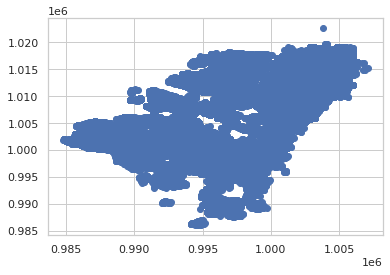

In [ ]:
plt.scatter(ofertas.x, ofertas.y)

In [ ]:
geometry = [Point(xy) for xy in zip(ofertas_sp['x'], ofertas_sp['y'])]
gdf = gpd.GeoDataFrame(ofertas_sp)
gdf['geometry'] = geometry
crs = 'epsg:3116'
gdf.crs = crs

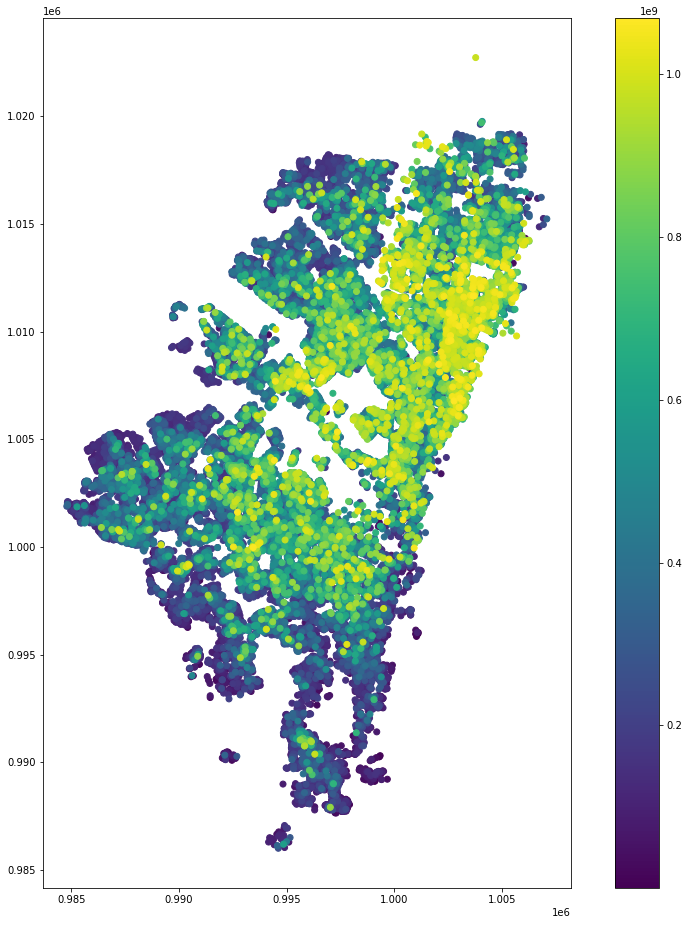

In [ ]:
gdf.plot(column='vfventa2020', legend=True, figsize=(16,16))

In [ ]:
gdf.total_bounds

array([ 984796.07472553,  986009.45502402, 1007083.80363351,
       1022723.34228866])

In [ ]:
gdf_base = gdf.to_crs(epsg=3857)

In [ ]:
w = weights.distance.KNN.from_dataframe(gdf, k=10)

/usr/local/lib/python3.6/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


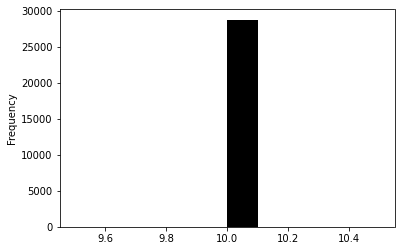

In [ ]:
pd.Series(w.cardinalities).plot.hist(color='k');

In [ ]:
gdf['vfventa2020_lag'] = weights.spatial_lag.lag_spatial(w, gdf['vfventa2020'])

In [ ]:
gdf['vfventa2020_std'] = ( gdf['vfventa2020'] - gdf['vfventa2020'].mean() )\
                    / gdf['vfventa2020'].std()
gdf['vfventa2020_lag_std'] = ( gdf['vfventa2020_lag'] - gdf['vfventa2020_lag'].mean() )\
                    / gdf['vfventa2020_lag'].std()

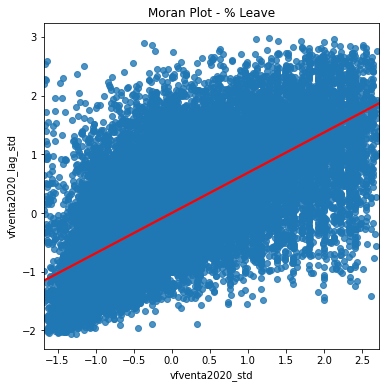

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='vfventa2020_std', y='vfventa2020_lag_std', 
                ci=None, data=gdf, line_kws={'color':'r'})
# ax.axvline(0, c='k', alpha=0.5)
# ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

##  spatial autocorrelation indices

In [ ]:
w.transform = 'R'
moran = esda.moran.Moran(gdf['vfventa2020'], w)

In [ ]:
moran.I,moran.p_sim

(0.5031883244207209, 0.001)

In [ ]:
geary = esda.geary.Geary(gdf['vfventa2020'], w)
geary.C,geary.p_sim

(0.4902410240484735, 0.001)

Reject of null hipothesys of no spatial autocorrelation


- Problems: heteroscedasticity in the models may be caused for this autocorrelation
- Solutions:
spatial models for adding lag or error of the dependent variable (hard work for process in local env)